Determine Roche radii of the cores and other few things

In [1]:
import sys
import matplotlib.pyplot as plt
# Mathieu's default plots
# see https://github.com/mathren90/plotFunc
sys.path.append('/mnt/home/mrenzo/codes/python_stuff/plotFunc/')
from plotDefaults import *
from MESAreader import *

In [2]:
set_plotDefaults()

done in plotDefaults.py


In [5]:
# location of the MESA output
root = "/mnt/ceph/users/mrenzo/RUNS/Radii_RSG_cores/"
folders = glob.glob(root+'/*/')
# print(folders)

def getM(f):
    return float(f.split('cores/')[-1].rstrip('/'))

def get_t_kh(L,R,M):
    global G_cgs, Msun, Rsun_cm, Lsun, secyer # these are from $MESA_DIR/const/public/const_def.f90
    # convert to cgs
    M *= Msun
    R *= Rsun_cm
    L *= Lsun
    # same formula coded in MESA, 0.75 geometric factor
    t_kh = 0.75*G_cgs*M*M/(R*L) # sec
    t_kh = t_kh/secyer # years
    return t_kh


/mnt/home/mrenzo/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  func(*args, **kwargs)


/mnt/home/mrenzo/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


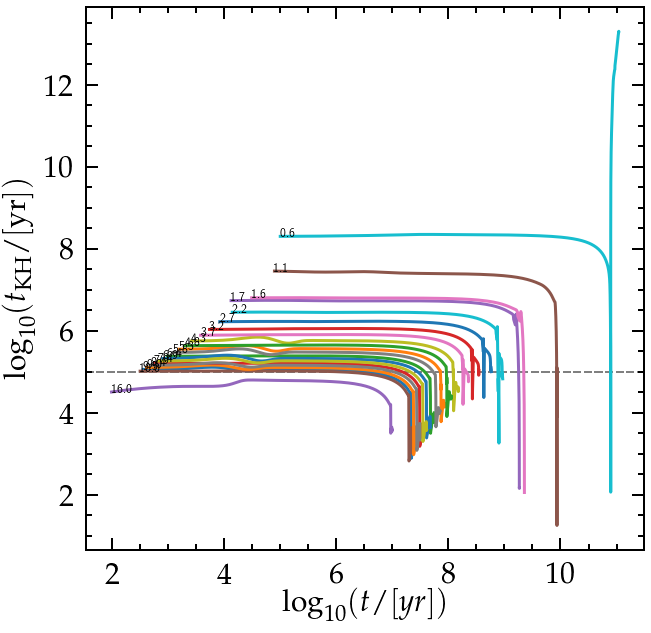

In [6]:
# plot KH timescale as a function of time for a grid of models

fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100)
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:,:])

ax.set_xlabel(r"$\log_{10}(t / [yr])$",fontsize=30)
ax.set_ylabel(r"$\log_{10}(t_\mathrm{KH}/\mathrm{[yr]})$",fontsize=30)

for f in folders:
    if getM(f) != 0.1:
        src, col = getSrcCol(f+'LOGS/history.data', True, True)
        R = 10**(src[:, col.index('log_R')]) # Rsun units
        M = src[:, col.index("star_mass")] #Msun
        L = 10**(src[:, col.index("log_L")]) #Lsun
        t = src[:, col.index("star_age")]
        t_kh = get_t_kh(L,R,M)
        ax.plot(np.log10(t), np.log10(t_kh))
        ax.text(np.log10(t[0]),np.log10(t_kh)[0], "%.1f"%getM(f), fontsize=12, transform=ax.transData)
        ax.axhline(5,0,1,lw='2',ls='--',c='#808080',zorder=0)


(0, 1)

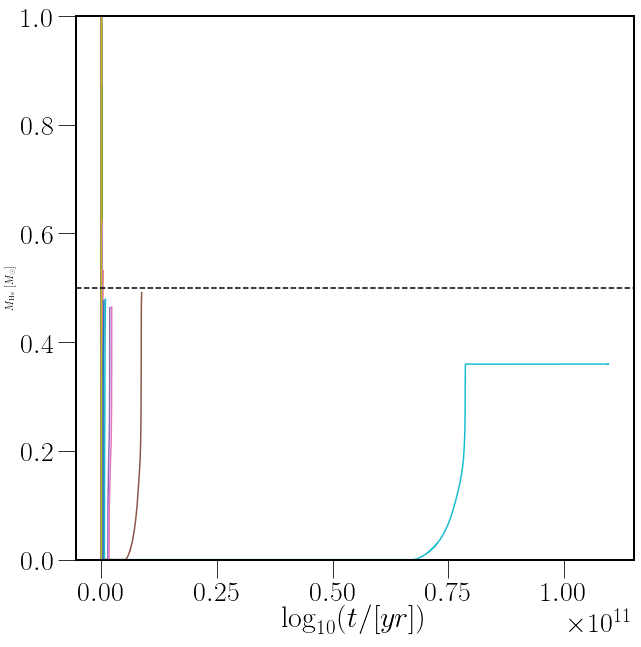

In [6]:
fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100)
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:,:])

ax.set_xlabel(r"$\log_{10}(t / [yr])$",fontsize=30)
ax.set_ylabel(r"$M_\mathrm{He} \ [M_\odot]$")

for f in folders:
    if getM(f) != 0.1:
        src, col = getSrcCol(f+'LOGS/history.data', True, True)
        t = src[:, col.index("star_age")]
        mhecore = src[:, col.index("he_core_mass")]
        ax.plot(t, mhecore)
        # ax.text(t[-1], mhecore[-1], f.split('/')[-2])
        

ax.axhline(0.5, 0,1, c='k', ls='--')
ax.set_ylim(0,1)

In [7]:
# Eggleton 1983 Formula

def func(q):
    return ((0.49*q**(2/3.0))/(0.6*q**(2/3.0)+np.log(1+q**(1/3.0))))


def Roche_radius(q, a):
    # Eggleton 1983 formula for Roche Lobe
    # q = M1/M2
    # rl1 = a*((0.49*q**(2/3.0))/(0.6*q**(2/3.0)+np.log(1+q**(1/3.0))))
    # q = M2/M1
    rl = a*func(q)
    return rl


def acrit(Rcore, q):
    # returns separation a such that R_core = R_roche_lobe_core corresponding to the merger
    # Egglenton's formula
    # R_roche_lobe_core = a*f(q) => a = R_roche_lobe_core/f(q) => acrit = R_core/f(q)

    return Rcore/func(q)
    
def get_fgw_from_sep_mass(M1, M2, a):
    ## assumes masses in solar masses and separation in solar radii
    # v = omega*a
    # omega^2 a^3 = G(M1+M2) # 3rd Kepler's law
    #omega = sqrt(G(M1+M2)/a^3)
    # P = 24/omega
    omega = np.sqrt((G_cgs*(M1+M2)*Msun)/(a*Rsun_cm)**3)
    omega_GW = 2*omega
    # P = 2*math.pi/omega # in sec
    # Pdays = P/86400 # in days
    
    # print("omega=",omega, "Hz")
    # print("omega_GW", omega_GW, "Hz")
    return omega_GW

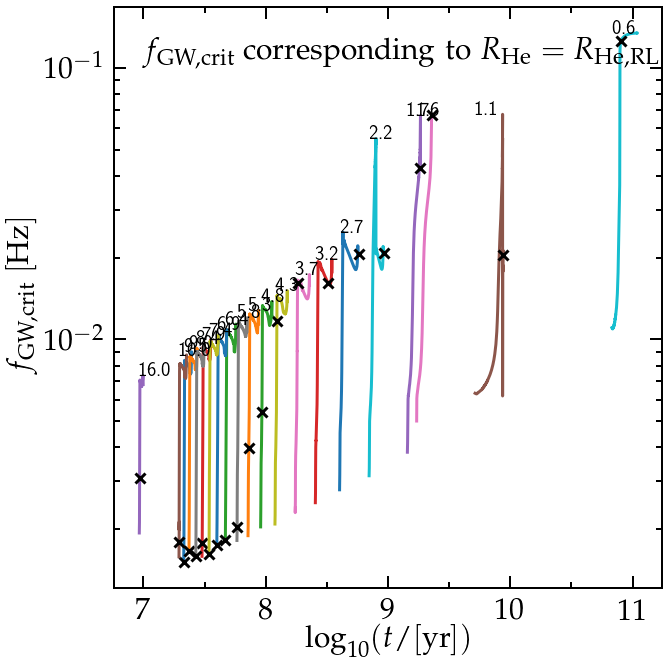

In [8]:
# critical GW frequency as a function of time for all masses I have
fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(10,10)
ax = plt.subplot(gs[:,:])

Mcompanion = 0.3 #Msun, assuming a WD

for f in folders:
    M = getM(f)
    if M != 0.1:
        src, col = getSrcCol(f+'LOGS/history.data', True, True)
        he_core_mass = src[:, col.index("he_core_mass")]
        ind = he_core_mass != 0
        he_core_mass = he_core_mass[ind]
        he_core_radius = src[ind, col.index("he_core_radius")]
        t = np.log10(src[ind, col.index("star_age")])

        a_cr = acrit(he_core_radius,he_core_mass/Mcompanion)
        f_gw_crit = get_fgw_from_sep_mass(he_core_mass, Mcompanion, a_cr)
        ax.plot(t,f_gw_crit, lw=3)

        i = np.argmin(np.absolute(he_core_mass - 0.5))
        time = t[i]
        critf = get_fgw_from_sep_mass(he_core_mass[i], Mcompanion, acrit(he_core_radius[i],he_core_mass[i]/Mcompanion))
        ax.plot(time, critf,marker='x', ms=10, c='k', mew=3)
        
        ax.text(t[0],max(f_gw_crit), "%.1f"%getM(f), fontsize=20, transform=ax.transData)

ax.set_yscale('log')
ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, labelsize=30, direction='in')
ax.set_xlabel(r"$\log_{10}(t / [\mathrm{yr}])$",fontsize=30)
ax.set_ylabel(r"$f_\mathrm{GW,crit}\ [\mathrm{Hz}]$", fontsize=30)
ax.text(0.05,0.9,r"$f_\mathrm{GW,crit} \ \mathrm{corresponding\ to} \ R_\mathrm{He} = R_\mathrm{He, RL}$", transform=ax.transAxes,fontsize=30)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.tight_layout()
# plt.savefig("/mnt/home/mrenzo/TMP/CE_LISA/f_GW_crit.pdf",dpi=300)

# ax.text(0.05,0.85,r"$\mathrm{assuming} \ M_2=0.3\,M_\odot)$", transform=ax.transAxes,fontsize=30)

/mnt/home/mrenzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/mnt/home/mrenzo/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  func(*args, **kwargs)


/mnt/home/mrenzo/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


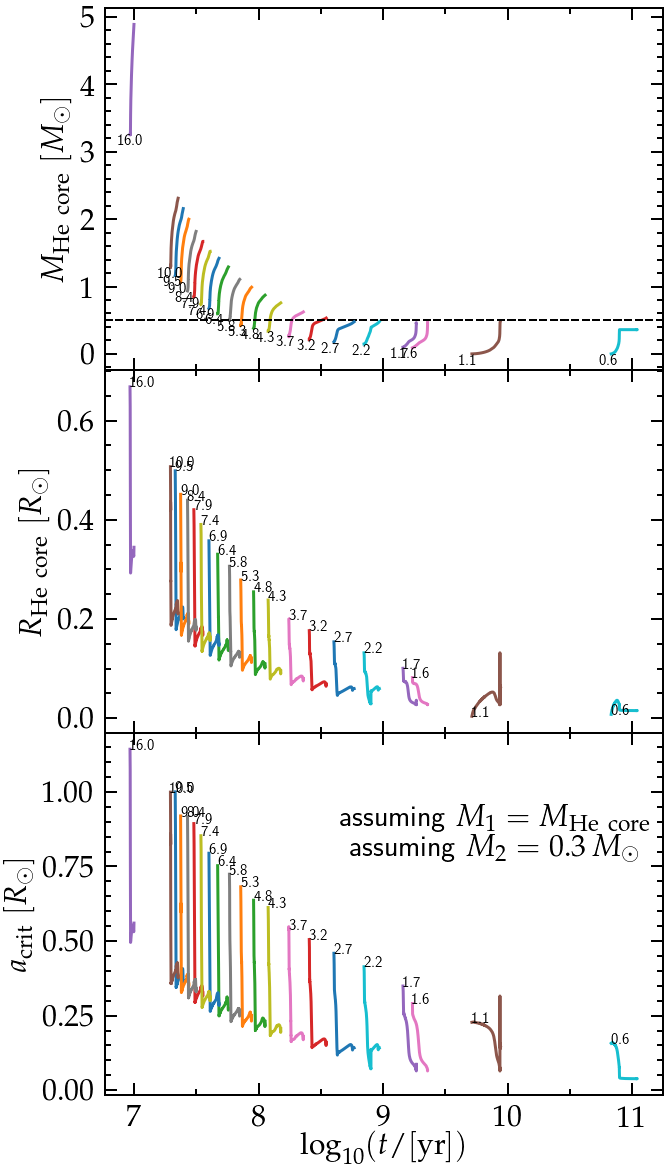

In [9]:
# print M_he as a function of time
fig = plt.figure(figsize=(10., 20.))
gs = gridspec.GridSpec(120,120)
gs.update(wspace=0,hspace=0)# top=1.1)
ax = plt.subplot(gs[:40,:])
bx = plt.subplot(gs[40:80,:])
cx = plt.subplot(gs[80:,:])

for axis in [ax,bx,cx]:
    axis.tick_params(axis='both', which='major', width=2, top="on", right="on",
               length=12, pad=10, labelsize=30, direction='in')
    axis.tick_params(axis='both', which='minor', width=2, top="on", right="on",
                     length=6, pad=10, direction='in')

    axis.xaxis.set_major_locator(MultipleLocator(1))
    axis.xaxis.set_minor_locator(MultipleLocator(0.5))
# ax.yaxis.set_major_locator(MultipleLocator(5))
# ax.yaxis.set_minor_locator(MultipleLocator(1))


cx.set_xlabel(r"$\log_{10}(t / [\mathrm{yr}])$",fontsize=30)
ax.set_ylabel(r"$M_\mathrm{He\ core} \ [M_\odot]$",fontsize=30)
bx.set_ylabel(r"$R_\mathrm{He\ core} \ [R_\odot]$",fontsize=30)
cx.set_ylabel(r"$a_\mathrm{crit} \ [R_\odot]$",fontsize=30)

for f in folders:
    if getM(f) != 0.1:
        src, col = getSrcCol(f+'LOGS/history.data', True, True)
        he_core_mass = src[:, col.index("he_core_mass")]
        ind = he_core_mass != 0
        he_core_mass = he_core_mass[ind]
        he_core_radius = src[ind, col.index("he_core_radius")]
        t = np.log10(src[ind, col.index("star_age")])
        
        ax.text(t[0]-0.1,he_core_mass[0]-0.15, "%.1f"%getM(f), fontsize=15, transform=ax.transData)
        ax.axhline(0.5,0,1,lw='2',ls="--",c='k')
        bx.text(t[0],he_core_radius[0], "%.1f"%getM(f), fontsize=15, transform=bx.transData)
        cx.text(t[0],acrit(he_core_radius,he_core_mass/0.3)[0], "%.1f"%getM(f), fontsize=15, transform=cx.transData)      
        
        ax.plot(t, he_core_mass)
        bx.plot(t, he_core_radius)
        ## assume a WD companion of 0.3Msun
        cx.plot(t, acrit(he_core_radius,he_core_mass/0.3))
 

cx.text(0.7,0.75,"assuming  $M_1 = M_\mathrm{He\ core}$", va="center", ha="center", fontsize=30, transform=cx.transAxes)
cx.text(0.7,0.67,"assuming $M_2=0.3\,M_\odot$", va="center", ha="center", fontsize=30, transform=cx.transAxes)
#ax.text(0.7,0.75,"assuming $M2=0.3\,M_\odot$", va="center", ha="center", fontsize=30, transform=ax.transAxes)
plt.tight_layout()
# plt.savefig(root+"/core_masses_RLOBE.pdf")
        